# vote_coefficients_0x12BB5bBbFE596dbc489d209299B8302c3300fa40_4


In [1]:
import os
from pathlib import Path
import numpy as np

import pandas as pd

from sbdata.FlipsideApi import FlipsideApi

# Set path to data folder
current_dir = Path(os.getcwd())
PATH_TO_EXPORT = os.path.join(current_dir.parent.parent, 'tx_data', 'all_beta_rounds')
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')
DATA_DIR_GITCOIN = os.path.join(current_dir.parent.parent, 'data-gitcoin')
CSV_GITCOIN_GRANTS = 'vote_coefficients_0x12BB5bBbFE596dbc489d209299B8302c3300fa40_4.csv'

# read the address from oss grant

api_key = os.environ['FLIPSIDE_API_KEY']
flipside_api = FlipsideApi(api_key, max_address=400)
PATH_TO_VOTES = os.path.join(DATA_DIR, "votes_baoki.csv")
PATH_TO_GRANTS = os.path.join(DATA_DIR, "all-allo-rounds.csv")
PATH_TO_PROJECTS = os.path.join(DATA_DIR, "projects_QmQurt.csv")
PATH_TO_VOTES_GITCOIN = os.path.join(DATA_DIR_GITCOIN, CSV_GITCOIN_GRANTS)

# load data
df_votes = pd.read_csv(PATH_TO_VOTES_GITCOIN)
df_grants = pd.read_csv(PATH_TO_GRANTS)
df_application = pd.read_csv(PATH_TO_PROJECTS)
# Lowercase all addresses because flipside api return lowercase address
#id,projectId,applicationId,roundId,token,voter,grantAddress,amount,amountUSD,coefficient,status,last_score_timestamp,type,success,rawScore,threshold
df_grants['Round ID'] = df_grants['Round ID'].str.lower()
str_columns_votes = ['id', 'projectId', 'roundId', 'voter', 'grantAddress']
df_votes[str_columns_votes] = df_votes[str_columns_votes].applymap(lambda x: x.lower())

str_columns_application = ['id', 'roundId', 'metadata.application.round', 'metadata.application.recipient']
df_application[str_columns_application] = df_application[str_columns_application].applymap(lambda x: str(x).lower())

# round_id = df_grants[df_grants['Round name'] == 'Web3 Community and Education']['Round ID'].values[0]
array_unique_address = df_votes['voter'].unique()

array_unique_address = np.char.lower(array_unique_address.astype(str))


C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_15020\1947096817.py:26: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes = pd.read_csv(PATH_TO_VOTES_GITCOIN)


In [2]:
from sbutils import LoadData

# Load data
data_loader = LoadData.LoadData(PATH_TO_EXPORT)
df_tx = data_loader.create_df_tx('ethereum', array_unique_address)

In [3]:
len(array_unique_address)

14554

In [4]:
df_tx.EOA.nunique()

14554

In [5]:
c = np.setxor1d(array_unique_address, df_tx.EOA.values)
c

array([], dtype=object)

## Computing legos booleans

In [6]:
from sblegos.TransactionAnalyser import TransactionAnalyser as txa
tx_analyser = txa(df_tx, df_address=pd.DataFrame(np.intersect1d(df_tx.EOA.unique(), array_unique_address)))

use matching address because some addresses are not in the extracted data set

In [7]:
df_matching_address = pd.DataFrame(df_tx.EOA.unique(), columns=["address"])
df_matching_address.head(2)

,address
0,0x00000000037a08ce8c4917a5c58f40c85367df0c
1,0x00000001985c6a08963eef53821c78aa84318b42


Compute the boolean 

less than 10 x transaction are not performant legos so we don't use it, has same seed is computed as an intermediarry to get the seed_suspicious flag

In [8]:
df_matching_address['seed_same_naive'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed_naive(x))
df_matching_address['seed_same'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed(x))
df_matching_address['seed_suspicious'] = df_matching_address.loc[:, 'seed_same_naive'].ne(df_matching_address.loc[:, 'seed_same'])
df_matching_address['less_5_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 5))
# df_matching_address['less_10_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 10))
df_matching_address['interacted_other_ctbt'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_interacted_with_other_contributor(x))

In [9]:
print(f'Number of voters: {len(df_matching_address)}')

Number of voters: 14554


In [10]:
df_matching_address.sum()

address                  0x00000000037a08ce8c4917a5c58f40c85367df0c0x00...
seed_same_naive                                                      10325
seed_same                                                            10758
seed_suspicious                                                        489
less_5_tx                                                              229
interacted_other_ctbt                                                 3994
dtype: object

### Investigating the boolean seed suspicious

In [11]:
df_matching_address[df_matching_address['seed_suspicious'] == True]

,address,seed_same_naive,seed_same,seed_suspicious,less_5_tx,interacted_other_ctbt
42,0x006970fd32059734e586a323b13fc1ce625f296b,False,True,True,False,False
43,0x006ad7df1dfad4af7d182b9598a294d7c601488b,False,True,True,False,False
60,0x00bb8b005d090b6a59aa5c9550f3f9629edb18bf,False,True,True,False,False
61,0x00bf528c0e7ce508e6c20642fdae6b8728e4122b,False,True,True,False,True
97,0x0150c608a25176c08d9bc8b43d0dc64e4c9f4a58,False,True,True,False,False
...,...,...,...,...,...,...
14488,0xfeeda41a603ea7da0b8638ac885be0b2399b4b29,False,True,True,False,False
14495,0xff17b13fde1b3738b473d24ca640379f8e163738,False,True,True,False,False
14525,0xff938bd81c2671c28caf920d8015bad9fb816d59,False,True,True,False,True
14531,0xffa95c8ea548c484e0c40d5e985237db070d6211,False,True,True,False,False


In [12]:
# projects_voted = df_votes[df_votes['voter'] == '0xc28064b875ae25f9a2ca28c08f116a5c26229f69']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'status', 'metadata.application.round']].reset_index(drop=True)

Some of the projects he donated to are in the list of Rejected projects showing that this address is indeed a sybil. And may have contributed to ohter fraudulent projects.

- Pulsar is not very active and is forked code for the most part
- Fusion not very active on github but has a lot of activity on twitter 
- Share suspicious Github with no activity, twitter does not exists: suspicious

Other projects are ok

In [13]:
# projects_voted = df_votes[df_votes['voter'] == '0x61ffe691821291d02e9ba5d33098adcee71a3a17']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title']].reset_index(drop=True)

In [14]:
# projects_voted = df_votes[df_votes['voter'] == '0xe51200a4d161935fc311ed8a0401feb1abf20e3a']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title']].reset_index(drop=True)

The boolean seed suspicious is not relevant for that round we will not use it for the analysis.

### Computing the new dex interaction score
It was investigated in another notebook 

In [15]:
def get_interacted_address(from_address, to_address, address):
    if from_address == address:
        return to_address
    else:
        return from_address

def count_interaction_with_any(tx_analyser, address, array_address):
    """
    Return an integer of the number of interactions with the addresses in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    count_interaction_with_any : int
        The number of interactions with the addresses in the array_address
    """
    tx_analyser.set_group_by_sorted_EOA()

    df = tx_analyser.gb_EOA_sorted.get_group(address)
    address_interacted = df.apply(lambda x: get_interacted_address(x['from_address'], x['to_address'], address), axis=1)
    tx_boolean_interacted = address_interacted.isin(array_address)
    return tx_boolean_interacted.sum()

def has_interacted_with_any(tx_analyser, address, array_address):
    """
    Return a boolean whether the address has interacted with any address in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    has_interacted_with_any : bool
        True if the address has interacted with one or more of the addresses in the array_address
    """
    count_interaction_with_any = count_interaction_with_any(tx_analyser, address, array_address)
    return count_interaction_with_any > 0

In [16]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'pool' 
;'''
df_label = flipside_api.execute_query(label_query)

In [17]:
# extract all the pool addresses
array_pool_address = df_label['address'].unique()

In [18]:
tx_analyser.set_group_by_sorted_EOA()

In [19]:
# Compute the number of interactions with any of the pools for each address
df_matching_address['count_interaction_with_pool'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, array_pool_address))

In [20]:
(df_matching_address['count_interaction_with_pool'] > 0).sum() / len(df_matching_address)

0.35103751545966744

In [21]:
label_query = '''
SELECT DISTINCT(LABEL_SUBTYPE)
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
;'''
df_distinct_labels = flipside_api.execute_query(label_query)

In [22]:
df_distinct_labels.label_subtype.unique()

array(['hot_wallet', 'cold_wallet', 'deposit_wallet', 'staking_contract',
       'rewards', 'dao', 'mining_pool', 'donation_address', 'reserve',
       'multisig', 'airdrop_contract', 'contract_deployer', 'voting',
       'distributor_cex', 'escrow', 'chadmin', 'token_contract', 'bridge',
       'mint_burn', 'mint_contract', 'nf_token_contract',
       'nf_position_manager', 'token_distribution', 'swap_router', 'pool',
       'router', 'general_contract', 'swap_contract', 'toxic', 'vault',
       'fee_wallet', 'governance', 'strategy', 'marketplace',
       'foundation', 'oracle', 'aggregator_contract', 'treasury',
       'token_sale'], dtype=object)

From these tags lets flag any address that have interacted with a toxic wallet

In [23]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'toxic'
;'''
df_toxic = flipside_api.execute_query(label_query)

In [24]:
df_toxic.shape

(4857, 6)

In [25]:
# Compute the number of interactions with any of the scam for each address
df_matching_address['count_interaction_with_toxic'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_toxic['address'].unique()))

In [26]:
print(f'Percentage of addresses that have interacted with a toxic address: {int((df_matching_address["count_interaction_with_toxic"] > 0).sum() / len(df_matching_address) *100)}%')

Percentage of addresses that have interacted with a toxic address: 1%


In [27]:
tag_query = '''
SELECT DISTINCT(TAG_TYPE)
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
;'''
df_distinct_tags = flipside_api.execute_query(tag_query)

In [28]:
df_distinct_tags.tag_type.values

array(['cex', 'NFT', 'contract', 'wallet', 'dex', 'chainlink oracle',
       'nft', 'activity', 'dydx delegate', 'Aave Delegates',
       'Balancer Delegates'], dtype=object)

I found the tag_name "airdrop master" could be interesting 

In [29]:
query_airdrop_master = '''
SELECT BLOCKCHAIN, CREATOR, ADDRESS, TAG_NAME
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
AND TAG_NAME = 'airdrop master'
;
'''
df_airdrop_master = flipside_api.execute_query(query_airdrop_master)

In [30]:
# Compute the number of interactions with any of the aidrop for each address
df_matching_address['count_interaction_with_airdrop_m'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_airdrop_master['address'].unique()))
print(f'Percentage of addresses that interacted with airdrop master: {int((df_matching_address["count_interaction_with_airdrop_m"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with airdrop master: 14%


In [31]:
# Boolean whether the address is a aidrop master
df_matching_address['is_airdrop_master'] = df_matching_address['address'].apply(lambda x: x in df_airdrop_master['address'].unique()) 
print(f'Percentage of addresses that are airdrop master: {int((df_matching_address["is_airdrop_master"]).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that are airdrop master: 5%


In [32]:
sql_query_tornado = '''
SELECT DISTINCT PROJECT_NAME, ADDRESS
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND PROJECT_NAME LIKE '%tornado%'
;
'''
df_tornado = flipside_api.execute_query(sql_query_tornado)

In [33]:
# Count the number of interactions with tornado
df_matching_address['count_interaction_with_tornado'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_tornado['address'].unique()))
print(f'Percentage of addresses that interacted with tornado: {int((df_matching_address["count_interaction_with_tornado"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with tornado: 1%


In [34]:
# Count the number of time the address interatec with disperse contract: '0xD152f549545093347A162Dce210e7293f1452150'
df_matching_address['count_interaction_with_disperse'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, [str.lower('0xD152f549545093347A162Dce210e7293f1452150')]))
print(f'Percentage of addresses that interacted with disperse: {int((df_matching_address["count_interaction_with_disperse"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with disperse: 1%


In [35]:
df_matching_address.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,count_interaction_with_pool,count_interaction_with_toxic,count_interaction_with_airdrop_m,count_interaction_with_tornado,count_interaction_with_disperse
count,14554.000000,14554.000000,14554.000000,14554.000000,14554.000000
mean,4.003710,0.041432,1.687921,0.041157,0.098530
std,28.982165,0.748714,11.881740,0.788599,3.471618
min,0.000000,0.000000,0.000000,0.000000,0.000000
10%,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,0.000000,0.000000
90%,8.000000,0.000000,2.000000,0.000000,0.000000
max,2632.000000,56.000000,600.000000,55.000000,388.000000


In [36]:
df_matching_address['has_interaction_toxic'] = df_matching_address['count_interaction_with_toxic'] > 0
df_matching_address['has_no_pool_interaction'] = df_matching_address['count_interaction_with_pool'] < 6
df_matching_address['has_interaction_airdrop_m'] = df_matching_address['count_interaction_with_airdrop_m'] > 0
df_matching_address['has_interaction_tornado'] = df_matching_address['count_interaction_with_tornado'] > 0
df_matching_address['has_interaction_disperse'] = df_matching_address['count_interaction_with_disperse'] > 0

In [37]:
boolean_features = ['seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_airdrop_m', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'interacted_other_ctbt']

In [38]:
df_matching_address[boolean_features].sum() 

seed_suspicious                489
has_interaction_toxic          283
has_no_pool_interaction      12670
has_interaction_airdrop_m     2042
has_interaction_tornado        155
has_interaction_disperse       192
is_airdrop_master              831
interacted_other_ctbt         3994
dtype: int64

In [39]:
len(df_matching_address)

14554

In [40]:
(df_matching_address[boolean_features].sum(axis=1) > 2).sum()

1306

In [41]:
df_matching_address['count_flags'] = df_matching_address[boolean_features].sum(axis=1)

In [42]:
df_matching_address['suspicious_1'] = df_matching_address['count_flags'] > 2

In [43]:
df_suspicious_1 = df_matching_address[df_matching_address['suspicious_1'] == True]

### Investigating the grants receiving the most votes from the flagged addresses

In [44]:
df_vote_sus1 = df_votes[df_votes['voter'].isin(df_suspicious_1['address'])]
count_unique_vote_grant = df_votes.drop_duplicates(subset=['grantAddress', 'voter']).groupby('grantAddress')['id'].count().sort_values(ascending=False).reset_index()
count_suspicious_vote_grant = df_vote_sus1['grantAddress'].value_counts().reset_index()
df_vote_grant = count_unique_vote_grant.merge(count_suspicious_vote_grant, left_on='grantAddress', right_on='grantAddress', how='left').fillna(0).rename(columns={'id': 'count_unique_vote', 'count': 'count_suspicious_vote'})

In [45]:
df_vote_grant['percentage_suspicious_vote'] = df_vote_grant['count_suspicious_vote'] / df_vote_grant['count_unique_vote'] * 100
print(f'Number of suspicious votes {df_vote_sus1.shape[0]} Number of projects voted: {df_vote_sus1.grantAddress.nunique()}')
# Merge the project the user voted for and the projects 
gr_sus = df_vote_grant.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'percentage_suspicious_vote', 'count_suspicious_vote', 'roundId', 'status']].reset_index(drop=True).sort_values(by='percentage_suspicious_vote', ascending=False)
print(f'number of grants: {gr_sus.shape[0]}')
gr_sus.head(30)

Number of suspicious votes 7446 Number of projects voted: 111
number of grants: 112


,grantAddress,metadata.application.project.title,percentage_suspicious_vote,count_suspicious_vote,roundId,status
110,0xff16d64179a02d6a56a1183a28f1d6293646e2dd,Smart Invoice,40.000000,4.0,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
93,0xb62e762af637b49eb4870bce8fe21bfff189e495,Grant Review Dashboard,34.615385,9.0,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
109,0x048669c431230a9a8298b7ec045f1e1137827cca,"Blockhead: account tracker, block explorer and...",30.000000,3.0,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
103,0xa09a8433616ca0e1085248b15eaa06712c0f9cb5,DecentrAgora,26.666667,4.0,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
66,0xfede2257dc043f53a24ac7947218bacfb0013b09,Zuzu,26.229508,16.0,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
87,0x2f4bcd8adbe961290f2c4df752852466e7d655c9,StatelessArt,25.806452,8.0,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
102,0x9f4bc8b266ec6832d1339b62a6f04f35fcddd846,Project LION: Building Leo,25.000000,4.0,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
101,0xbbbb17a8c1ce64be28facd93b22450abb01b5dca,MEVBoostAA,25.000000,4.0,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
106,0x8d5d62099f937fb31e5f5078838836b3dc14eb24,HODL Totals,23.076923,3.0,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
42,0x5c04e7808455ee0e22c2773328c151d0dd79dc62,Flexible Voting,21.917808,32.0,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED


### Look at the addresses with at least one flag

We are going to review the addresses that have at least 1 flag:
- has_intercation_toxic 
- has_interaction_disperse
- has_interaction_airdrop_master
- is airdrop master
- seed suspicious
- interacted with other contributor and less than 5 tx

I decided to remove tornado cash because someone can be anonimous with out being a sybil

In [46]:
df_matching_address['interact_less_5tx'] = np.logical_and(df_matching_address['interacted_other_ctbt'], df_matching_address['less_5_tx'])

In [47]:
interaction_bool = ['has_interaction_toxic', 'has_interaction_airdrop_m', 'has_interaction_disperse', 'is_airdrop_master', 'seed_suspicious', 'interact_less_5tx']

In [48]:
df_matching_address[interaction_bool].sum()

has_interaction_toxic         283
has_interaction_airdrop_m    2042
has_interaction_disperse      192
is_airdrop_master             831
seed_suspicious               489
interact_less_5tx              27
dtype: int64

In [49]:
from scipy.spatial.distance import pdist

def jaccard_similarity_matrix(df):
    
    n = df.shape[1]
    scores = 1 - pdist(np.array(df).T, metric='jaccard')
    result = np.zeros((n,n))
    result[np.triu_indices(n, k=1)] = scores
    result += result.T
    np.fill_diagonal(result, 1)
    return pd.DataFrame(result, index=df.columns, columns=df.columns)

jaccard_similarity = jaccard_similarity_matrix(df_matching_address[interaction_bool])
jaccard_similarity

,has_interaction_toxic,has_interaction_airdrop_m,has_interaction_disperse,is_airdrop_master,seed_suspicious,interact_less_5tx
has_interaction_toxic,1.000000,0.085434,0.055556,0.075290,0.006519,0.000000
has_interaction_airdrop_m,0.085434,1.000000,0.048334,0.327634,0.012805,0.000000
has_interaction_disperse,0.055556,0.048334,1.000000,0.051387,0.004425,0.000000
is_airdrop_master,0.075290,0.327634,0.051387,1.000000,0.010720,0.000000
seed_suspicious,0.006519,0.012805,0.004425,0.010720,1.000000,0.013752
interact_less_5tx,0.000000,0.000000,0.000000,0.000000,0.013752,1.000000


<Axes: >

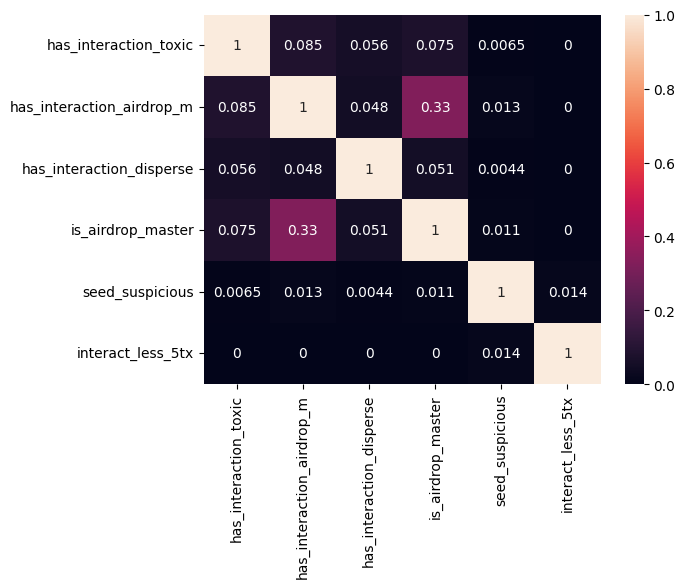

In [50]:
import seaborn as sns
sns.heatmap(jaccard_similarity, annot=True)

In [51]:
df_matching_address['flagged'] = df_matching_address[interaction_bool].sum(axis=1) > 0
df_interact_sus_2 = df_matching_address[df_matching_address['flagged'] == True]
print(f'Number of addresses that interacted with a suspicious contract or address: {df_interact_sus_2.shape[0]}')

Number of addresses that interacted with a suspicious contract or address: 2815


In [52]:
df_vote_sus_2 = df_votes[df_votes['voter'].isin(df_interact_sus_2['address'])]
# count_unique_vote_grant = df_votes.drop_duplicates(subset=['grantAddress', 'voter']).groupby('grantAddress')['id'].count().sort_values(ascending=False).reset_index().head(10)
count_suspicious_vote_grant_2 = df_vote_sus_2['grantAddress'].value_counts().reset_index()
df_vote_grant_2 = count_unique_vote_grant.merge(count_suspicious_vote_grant_2, left_on='grantAddress', right_on='grantAddress', how='left').fillna(0).rename(columns={'id': 'count_unique_vote', 'count': 'count_suspicious_vote'})

In [53]:
df_vote_grant_2['percentage_suspicious_vote'] = df_vote_grant_2['count_suspicious_vote'] / df_vote_grant_2['count_unique_vote'] * 100
print(f'Number of suspicious votes {df_vote_sus_2.shape[0]} Number of projects voted: {df_vote_sus_2.grantAddress.nunique()}')
# Merge the project the user voted for and the projects 
gr_sus_2 = df_vote_grant_2.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'percentage_suspicious_vote', 'count_suspicious_vote', 'roundId', 'status']].reset_index(drop=True).sort_values(by='percentage_suspicious_vote', ascending=False)
print(f'number of grants: {gr_sus.shape[0]}')
gr_sus_2.head(30)

Number of suspicious votes 16274 Number of projects voted: 112
number of grants: 112


,grantAddress,metadata.application.project.title,percentage_suspicious_vote,count_suspicious_vote,roundId,status
110,0xff16d64179a02d6a56a1183a28f1d6293646e2dd,Smart Invoice,70.000000,7,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
111,0x7e30fb962f951ef78d901865f87dd036fc5aa946,Shivarthu Democracy,66.666667,2,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
102,0x9f4bc8b266ec6832d1339b62a6f04f35fcddd846,Project LION: Building Leo,50.000000,8,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
109,0x048669c431230a9a8298b7ec045f1e1137827cca,"Blockhead: account tracker, block explorer and...",50.000000,5,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
93,0xb62e762af637b49eb4870bce8fe21bfff189e495,Grant Review Dashboard,50.000000,13,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
105,0x372628361ea225aef0fdba0ceadb297f2b4330ac,Wireshape - Open Blockchain for Product Data,50.000000,7,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
87,0x2f4bcd8adbe961290f2c4df752852466e7d655c9,StatelessArt,48.387097,15,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
106,0x8d5d62099f937fb31e5f5078838836b3dc14eb24,HODL Totals,46.153846,6,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
101,0xbbbb17a8c1ce64be28facd93b22450abb01b5dca,MEVBoostAA,43.750000,7,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED
77,0x0b7246ef74ca7b37fdc3d15be4f0b49876622f95,Praise,43.478261,20,0x12bb5bbbfe596dbc489d209299b8302c3300fa40,APPROVED


In [54]:
boolean_to_keep = ['seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'has_interaction_airdrop_m', 'interacted_other_ctbt', 'interact_less_5tx', 'flagged']

In [55]:
df_matching_address[boolean_to_keep].sum()

seed_suspicious                489
has_interaction_toxic          283
has_no_pool_interaction      12670
has_interaction_tornado        155
has_interaction_disperse       192
is_airdrop_master              831
has_interaction_airdrop_m     2042
interacted_other_ctbt         3994
interact_less_5tx               27
flagged                       2815
dtype: int64

In [56]:
final_merge = df_votes.merge(df_matching_address[boolean_to_keep + ['address']], left_on='voter', right_on='address', how='left')
print(f'number of squelched votes out of {final_merge.shape[0]}')
final_merge.shape[0] - final_merge[['coefficient']].sum() 

number of squelched votes out of 81811


coefficient    5598
dtype: int64

In [57]:
print(df_votes.shape)
print(final_merge.shape)

(81811, 16)
(81811, 27)


C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_15020\2681738413.py:7: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))


(81811, 19) votes stephi
(81811, 27) final merge
(81811, 29) votes merge


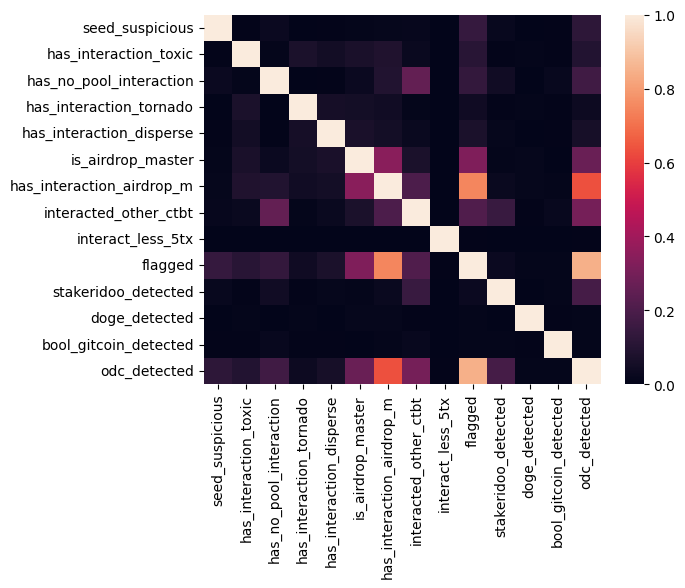

In [59]:
# Adding Stakeriddo and Gray flagged wallet

DATA_DIR_STEFI = os.path.join(current_dir.parent.parent, 'stefi')
CSV_STEPHI = 'sso_odc_analysis.csv'

# load data
df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))
print(f'{df_votes_stephi.shape} votes stephi')
print(f'{final_merge.shape} final merge')
df_stephi_bool_voter = df_votes_stephi[['voter', 'stakeridoo_detected', 'doge_detected']]
df_merge = final_merge.merge(df_stephi_bool_voter.drop_duplicates(subset=['voter']), left_on='voter', right_on='voter', how='left')
print(f'{df_merge.shape} votes merge')

df_merge['bool_gitcoin_detected'] = np.logical_not(df_merge.success.astype(bool))
df_merge['stakeridoo_detected'].fillna(False, inplace=True)
df_merge['doge_detected'].fillna(False, inplace=True)
df_merge['odc_detected'] = np.logical_or(np.logical_or(df_merge['stakeridoo_detected'], df_merge['doge_detected']), df_merge['flagged'])

boolean_jaccard = boolean_to_keep + ['stakeridoo_detected', 'doge_detected', 'bool_gitcoin_detected', 'odc_detected']
jaccard_similarity_2 = jaccard_similarity_matrix(df_merge[boolean_jaccard])
sns.heatmap(jaccard_similarity_2)

df_merge['proposed_coeff'] = np.logical_not(np.logical_or(df_merge['odc_detected'], df_merge['bool_gitcoin_detected']))

df_merge.drop(columns=['bool_gitcoin_detected', 'address']).to_csv(f'../output_gitcoin/n_{CSV_GITCOIN_GRANTS}', index=False)

In [60]:
df_merge[boolean_jaccard].sum(axis=0)

seed_suspicious               2319
has_interaction_toxic         1763
has_no_pool_interaction      69503
has_interaction_tornado       1271
has_interaction_disperse      1192
is_airdrop_master             5230
has_interaction_airdrop_m    12198
interacted_other_ctbt        22821
interact_less_5tx               83
flagged                      16274
stakeridoo_detected           3527
doge_detected                  215
bool_gitcoin_detected         1635
odc_detected                 19274
dtype: int64